In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.inspection import DecisionBoundaryDisplay

In [2]:
sns.set_theme()

data = load_breast_cancer(as_frame=True)

In [3]:
cancer = data.frame
cancer["target_cat"] = pd.Categorical.from_codes(cancer["target"], data.target_names)
cancer.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target,target_cat
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0,malignant
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0,malignant
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0,malignant
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0,malignant
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0,malignant


In [4]:
cancer = cancer.filter(regex="mean|target")
cancer.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,target,target_cat
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,0,malignant
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0,malignant
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0,malignant
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0,malignant
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0,malignant


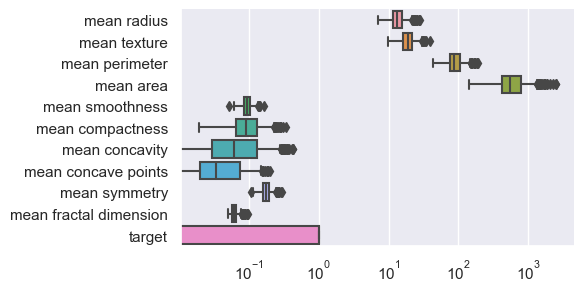

In [5]:
g = sns.catplot(cancer, kind="box", orient="h", height=3, aspect=2)
g.set(xscale="log")
plt.show()

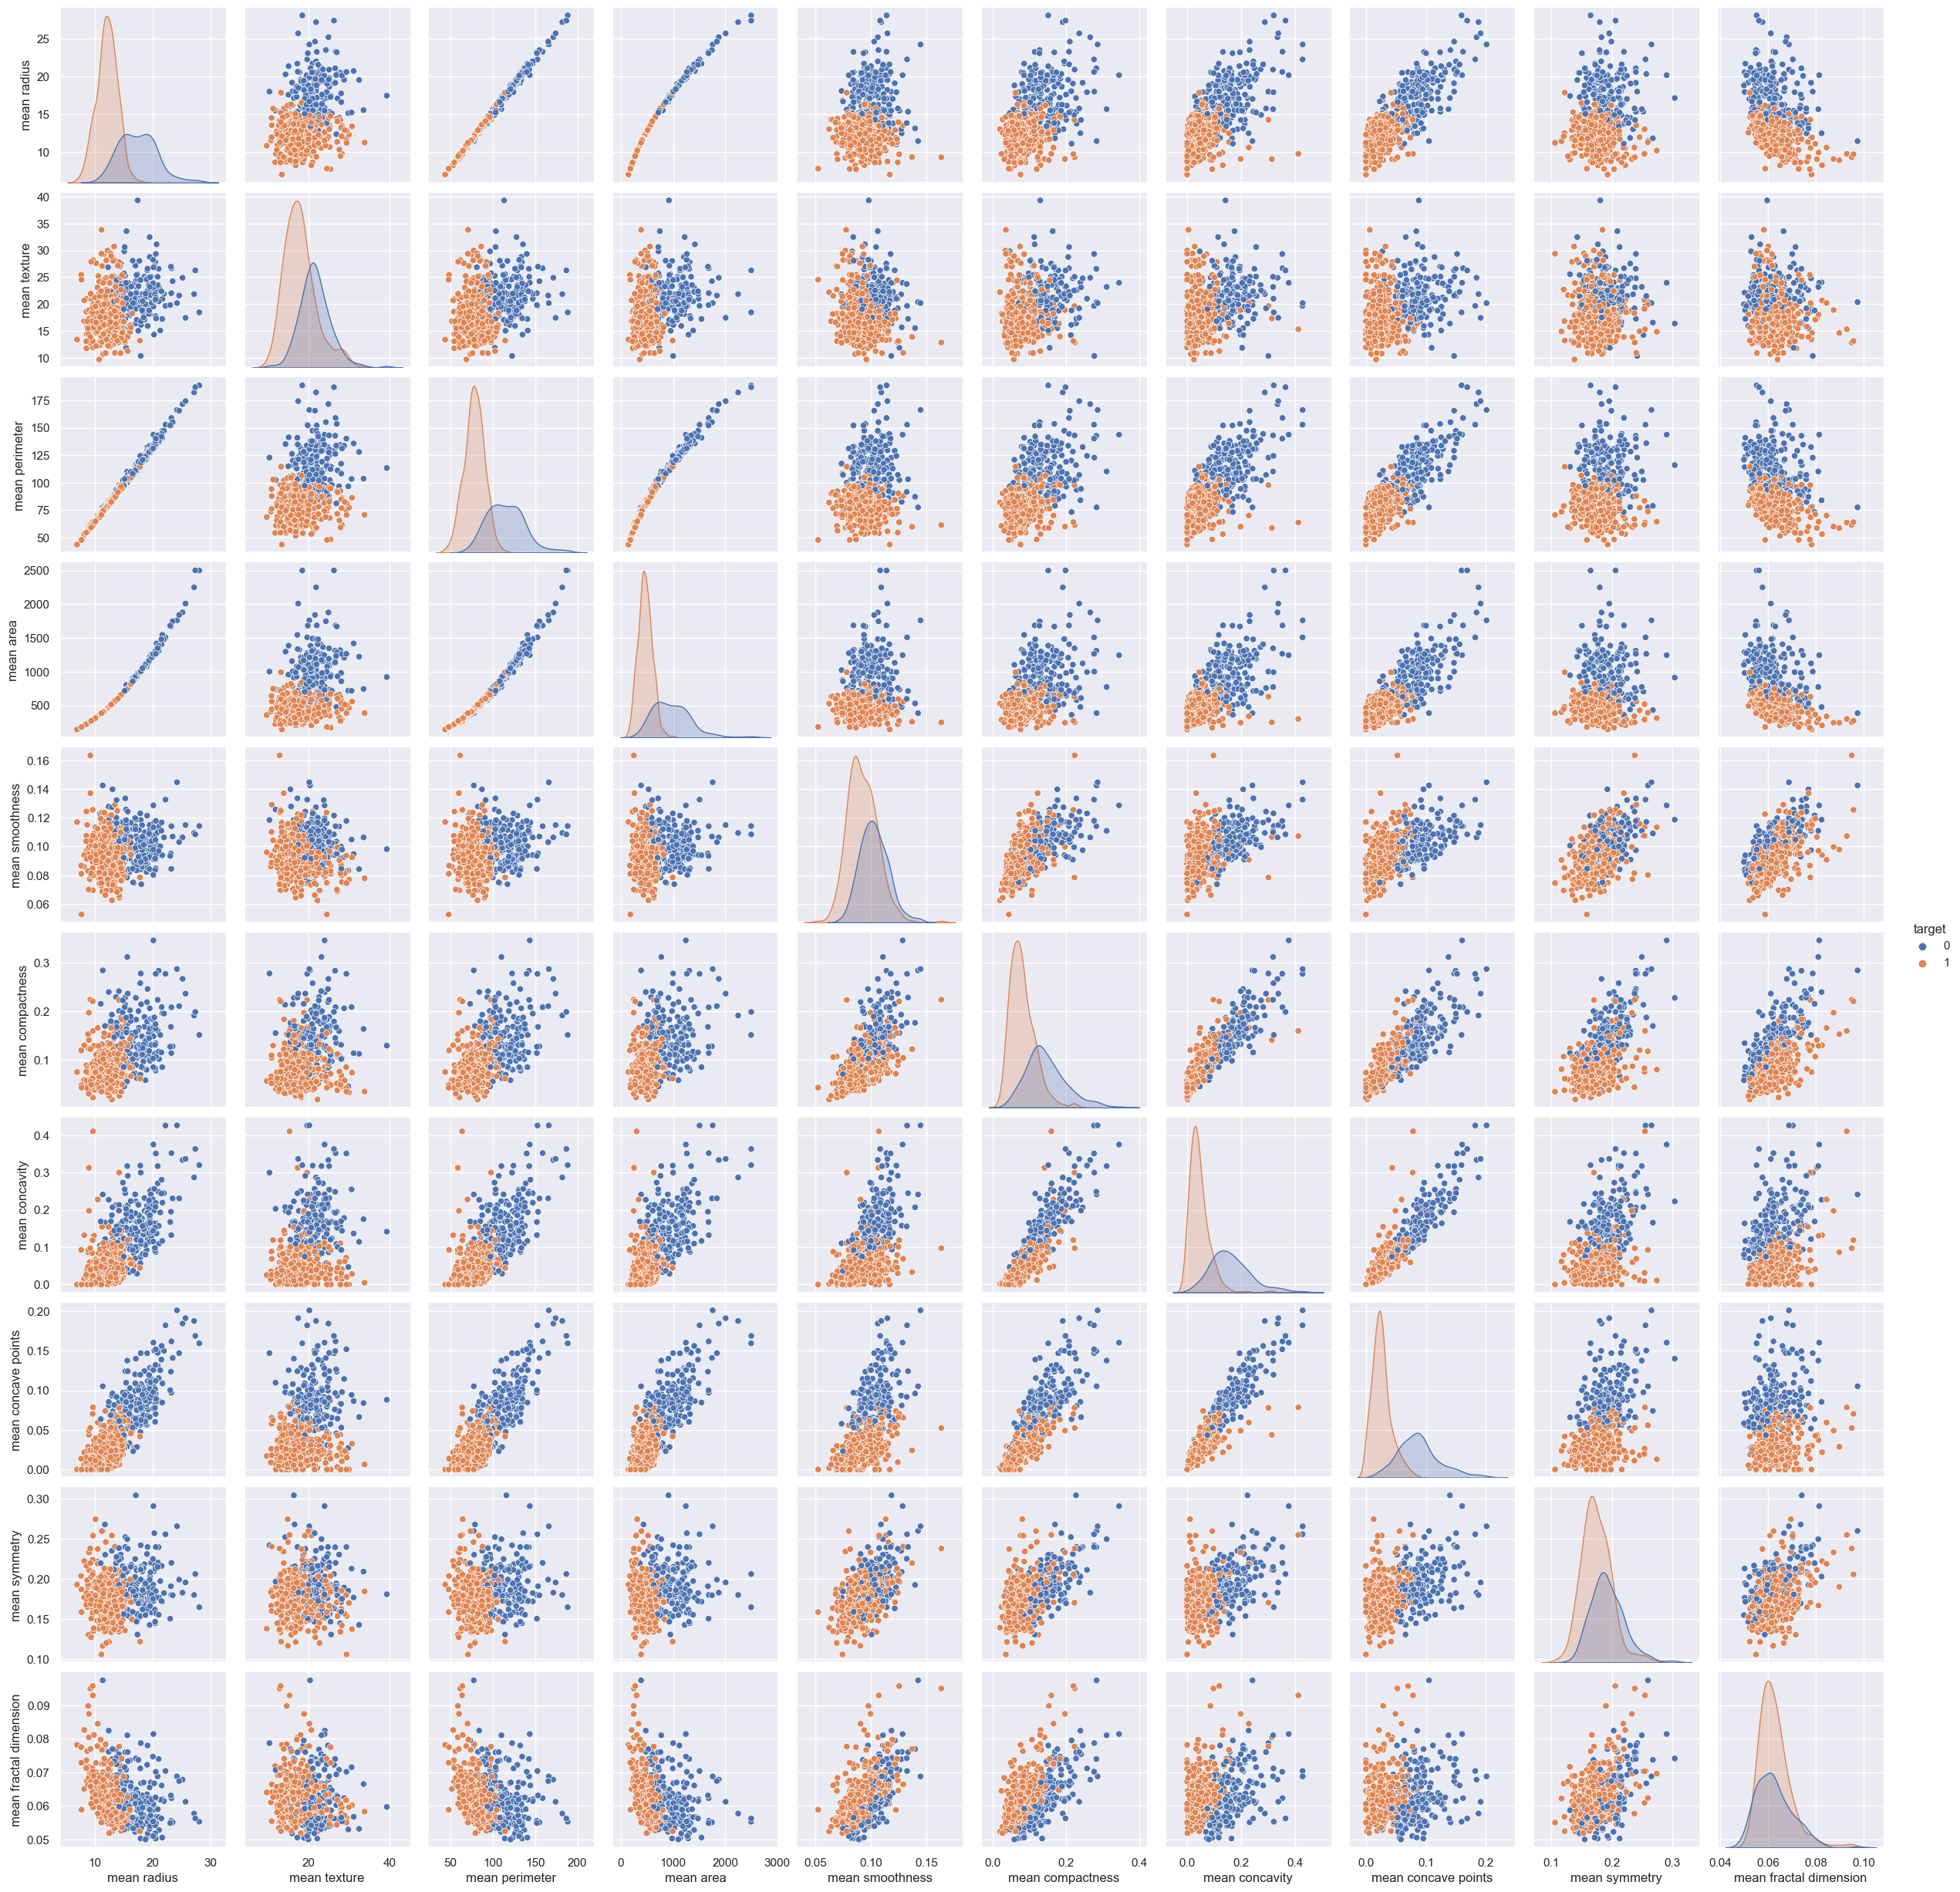

In [6]:
sns.pairplot(cancer, hue="target")
plt.show()

### Texture vs Concavity

best score:  0.8946126377891632  for k:  {'knn__n_neighbors': 32}


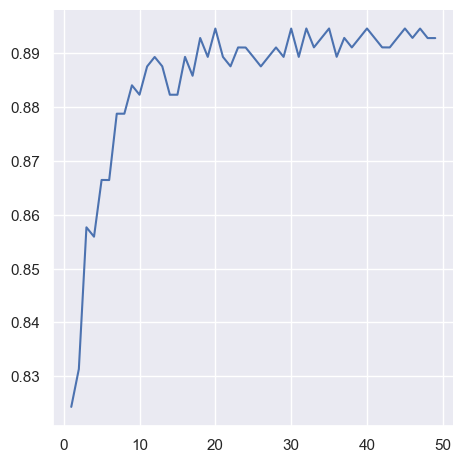

In [7]:
params = {"knn__n_neighbors": list(range(1, 50))}

gs = GridSearchCV(
    estimator=Pipeline([("Scaler", StandardScaler()), ("knn", KNeighborsClassifier())]),
    param_grid=params,
    cv=5
    )

gs.fit(X=cancer[["mean texture", "mean concavity"]], y= cancer["target"])

print("best score: ", gs.best_score_, " for k: ", gs.best_params_)

sns.relplot(x=params["knn__n_neighbors"], y = gs.cv_results_["mean_test_score"], kind="line")
plt.show()

In [8]:
X_train, X_test, y_train, y_test = train_test_split(cancer[["mean texture", "mean concavity"]], cancer["target"], stratify=cancer["target"], test_size=0.2, random_state=0)

Wir überprüfen kurz ob die relative Häufigkeit von positiven und negativen Samples in der Trainings- und in der Testmenge ähnlich sind:

In [9]:
print(cancer["target"].value_counts() / len(cancer))

print(y_train.value_counts() / len(y_train))
print(y_test.value_counts() / len(y_test))


1    0.627417
0    0.372583
Name: target, dtype: float64
1    0.626374
0    0.373626
Name: target, dtype: float64
1    0.631579
0    0.368421
Name: target, dtype: float64


Wir trainieren die KNN-Regression auf den Trainingsdaten und evaluieren auf den Testdaten.

### KNN-Regression ohne Skalierung (potentiell falsch!)

**Vorsicht:** Ohne Skalierung der Features wird die Abstandsberechnung durch diejenigen Features dominiert, welche größere Zahlenwerte aufweisen, d.h. wir machen einen inhaltlichen Fehler!

In [10]:
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X=X_train, y = y_train)

print(knn.score(X=X_test, y=y_test))

print(classification_report(y_true= y_test, y_pred=knn.predict(X=X_test)))

0.7105263157894737
              precision    recall  f1-score   support

           0       0.58      0.74      0.65        42
           1       0.82      0.69      0.75        72

    accuracy                           0.71       114
   macro avg       0.70      0.72      0.70       114
weighted avg       0.73      0.71      0.72       114



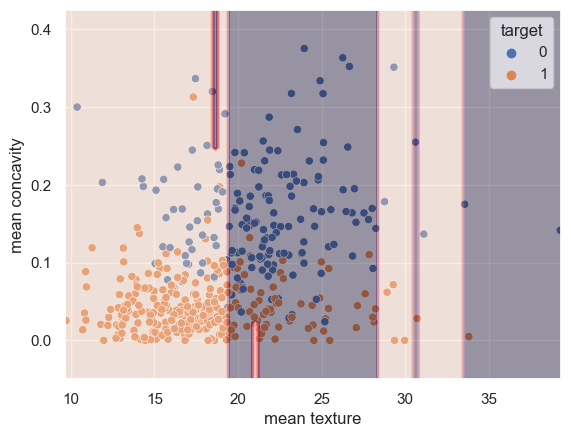

In [11]:
ax = sns.scatterplot(x=X_train["mean texture"], y = X_train["mean concavity"], hue = y_train)

DecisionBoundaryDisplay.from_estimator(ax=ax, estimator= knn, X= X_train, response_method="predict", alpha = 0.4, eps=0.05)

Wir sehen deutlich, dass die Abstandsmessung durch das Feature mit den größeren Zahlenwerten dominiert wird.

### KNN-Regression mit Skalierung

Auf Basis der Trainingdaten werden zunächst die Parameter für die Standardisierung bestimmt und im Objekt `scaler` gemerkt.
Anschließend transformieren wir die Trainingsdaten damit und trainieren das Modell auf den standardisierten Trainingsdaten.

Wichtig: 
- Die Parameter zur Skalierung der Trainingsdaten darf man nur aus den Trainingsdaten ermitteln. Würde man hierfür den vollständigen Datensatz nutzen, so würde man versehentlich Informationen aus den Testdaten in die Skalierung eingehen lassen.
- Zur Skalierung der Testdaten muss man die selben Parametern nutzen wie zur Skalierung der Testdaten, so dass diese zum trainierten Modell passen. (Es ist ein häufiger Fehler, die Trainingsdaten auch auf Mittelwert 0 und Standardabweichung 1 zu skalieren.)

In [12]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

X_test_scaled = scaler.transform(X_test)

In [13]:
knn_scaled = KNeighborsClassifier(n_neighbors=20)
knn_scaled.fit(X=X_train_scaled, y = y_train)

print(knn_scaled.score(X=X_test_scaled, y=y_test))

print(classification_report(y_true= y_test, y_pred=knn_scaled.predict(X=X_test_scaled)))

0.868421052631579
              precision    recall  f1-score   support

           0       0.83      0.81      0.82        42
           1       0.89      0.90      0.90        72

    accuracy                           0.87       114
   macro avg       0.86      0.86      0.86       114
weighted avg       0.87      0.87      0.87       114



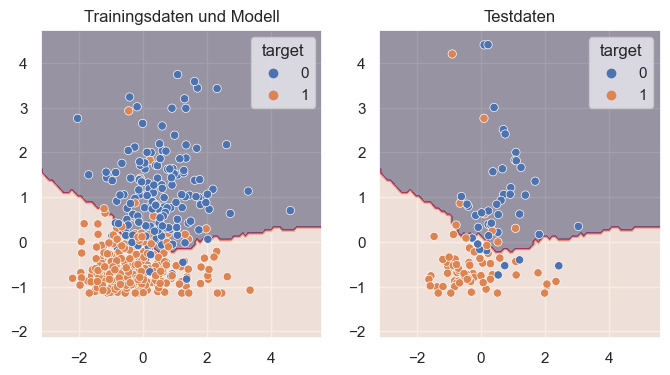

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

DecisionBoundaryDisplay.from_estimator(ax=axs[0], estimator= knn_scaled, X= X_train_scaled, response_method="predict", alpha = 0.4)
sns.scatterplot(ax=axs[0], x=X_train_scaled[:, 0], y = X_train_scaled[:, 1], hue = y_train)
axs[0].set(title="Trainingsdaten und Modell")

DecisionBoundaryDisplay.from_estimator(ax=axs[1], estimator= knn_scaled, X= X_train_scaled, response_method="predict", alpha = 0.4)
sns.scatterplot(ax=axs[1], x=X_test_scaled[:, 0], y = X_test_scaled[:, 1], hue = y_test)
axs[1].set(title="Testdaten")

plt.show()